# Programação Genética - Trabalho Final
## Leonardo Augusto Ferreira
### leauferreira@cpdee.ufmg.br

## Aluno: Yan Victor Gomes Ferreira
## Matrícula: 2021014155
## E-mail: eng-yanvictor@ufmg.br

In [224]:
# Anaconda
# !conda install gplearn
# !conda install eckity
# !conda install pmlb

# python - jupyter nootebook - colab
# !pip install gplearn
# !pip install eckity
# !pip install pmlb


# documentation:
# https://docs.sympy.org/latest/install.html
# https://github.com/EC-KitY/EC-KitY
# https://epistasislab.github.io/pmlb/

In [225]:
# Pacotes básicos
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'grid', 'notebook']) # Define estilos para o plot; necessário pacote scienceplots
import time
from tqdm import tqdm
import pandas as pd

# Pacote para os datasets
from pmlb import fetch_data

# Pacotes para avaliação dos modelos
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                            f1_score, mean_absolute_error, mean_squared_error, \
                            confusion_matrix, r2_score

# Pacote para modelos do gplearn
from gplearn.genetic import SymbolicClassifier, SymbolicRegressor

# Pacotes para modelos do EC-KitY
from eckity.algorithms.simple_evolution import SimpleEvolution
from eckity.sklearn_compatible.sk_classifier import SKClassifier
from eckity.sklearn_compatible.sk_regressor import SKRegressor
from eckity.breeders.simple_breeder import SimpleBreeder
from eckity.creators.gp_creators.ramped_hh import RampedHalfAndHalfCreator
from eckity.genetic_encodings.gp.tree.functions import f_add, f_mul, f_sub, f_div, f_neg, f_sqrt, f_log, f_abs, f_inv, f_max, \
    f_min
from eckity.genetic_encodings.gp.tree.utils import create_terminal_set
from eckity.genetic_operators.crossovers.subtree_crossover import SubtreeCrossover
from eckity.genetic_operators.mutations.subtree_mutation import SubtreeMutation
from eckity.genetic_operators.selections.tournament_selection import TournamentSelection
from eckity.statistics.best_avg_worst_size_tree_statistics import BestAverageWorstSizeTreeStatistics
from eckity.subpopulation import Subpopulation
from eckity.termination_checkers.threshold_from_target_termination_checker import ThresholdFromTargetTerminationChecker
#
# Adding your own functions
from eckity.sklearn_compatible.classification_evaluator import ClassificationEvaluator
from eckity.sklearn_compatible.regression_evaluator import RegressionEvaluator

---

## Funções auxiliares

In [226]:
def evaluateModel(y, yhat, task=''):
    '''Compila as principais métricas de avaliação de modelos de regressão e classificação'''
    
    if task=='regression':
        # Cálculo do MAE
        mae = round(mean_absolute_error(y, yhat),2)

        # Cálculo do MSE
        mse = round(mean_squared_error(y, yhat),2)

        # Cálculo do R2
        r2 = round(r2_score(y, yhat),2)
        
        # Concatenação das métricas
        metrics = [mae, mse, r2]
        
    elif task=='classification':
        # Cálculo da acurácia
        accuracy = round(accuracy_score(y, yhat),2)
        
        # Cálculo da precisão
        precision = round(precision_score(y, yhat),2)

        # Cálculo do recall
        recall = round(recall_score(y, yhat),2)

        # Cálculo do F1
        f1 = round(f1_score(y, yhat),2)
        
        # Concatenação das métricas
        metrics = [accuracy, precision, recall, f1]
    else:
        raise ValueError('''Defina o tipo de problema a ser resolvido ('classification' ou 'regression')''')
    
    return(metrics) 



# Modificada a partir de função do ChatGPT
def plotConfusionMatrix(y, yhat, target_names):
    """
    Função para plotar a matriz de confusão.

    Parâmetros:
    - y: saída esperada
    - yhat: saída do modelo
    - target_names: lista com os nomes das classes
    """
    
    cm = confusion_matrix(y_true=y, y_pred=yhat)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)

    # Adiciona o número de amostras em cada célula da matriz
    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, "{:.0f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.title('Matriz de Confusão da Saída')
    plt.ylabel('Classe Verdadeira')
    plt.xlabel('Classe Predita')
    plt.show()
    
    
    
def plotConfusionMatrixes(y, yhatGplearn, yhatECKitY, target_names=['Classe 0','Classe 1']):
    """
    Função para plotar duas matrizes de confusão lado a lado.

    Parâmetros:
    - y: saída esperada
    - yhat1: saída do primeiro modelo
    - yhat2: saída do segundo modelo
    - target_names: lista com os nomes das classes
    """
    cm1 = confusion_matrix(y_true=y, y_pred=yhatGplearn)
    cm2 = confusion_matrix(y_true=y, y_pred=yhatECKitY)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    plt.suptitle('Matrizes de confusão dos modelos gerados', fontsize=16)

    # Plotar primeira matriz de confusão
    axs[0].imshow(cm1, interpolation='nearest', cmap=plt.cm.Blues)
    axs[0].set_title('Modelo gplearn')
    axs[0].set_xticks(np.arange(len(target_names)))
    axs[0].set_yticks(np.arange(len(target_names)))
    axs[0].set_xticklabels(target_names)
    axs[0].set_yticklabels(target_names)

    thresh1 = cm1.max() / 2.0
    for i, j in np.ndindex(cm1.shape):
        axs[0].text(j, i, "{:.0f}".format(cm1[i, j]),
                    horizontalalignment="center",
                    color="white" if cm1[i, j] > thresh1 else "black")

    # Plotar segunda matriz de confusão
    axs[1].imshow(cm2, interpolation='nearest', cmap=plt.cm.Blues)
    axs[1].set_title('Modelo EC-KitY')
    axs[1].set_xticks(np.arange(len(target_names)))
    axs[1].set_yticks(np.arange(len(target_names)))
    axs[1].set_xticklabels(target_names)
    axs[1].set_yticklabels(target_names)

    thresh2 = cm2.max() / 2.0
    for i, j in np.ndindex(cm2.shape):
        axs[1].text(j, i, "{:.0f}".format(cm2[i, j]),
                    horizontalalignment="center",
                    color="white" if cm2[i, j] > thresh2 else "black")

    plt.tight_layout()
    plt.show()


def plotRegressions(y, yhatGplearn, yhatECKitY):
    
    fig, axes = plt.subplots(1,2,figsize=(12, 5))
    
    plt.suptitle('Resultados de regressão dos modelos gerados', fontsize=16)

    axes[0].plot(y)
    axes[0].plot(yhatGplearn)
    axes[0].set_title('Modelo gplearn', fontsize=12)

    axes[1].plot(y)
    axes[1].plot(yhatECKitY)
    axes[1].legend(loc='upper right', labels=['Saída esperada', 'Saída do modelo'], fontsize=10)
    axes[1].set_title('Modelo EC-KitY', fontsize=12)
    
    plt.show()


def normalizeDataset(x,y):
    '''Normaliza dados entre 0 e 1'''
    xMin = np.min(x, axis=0)
    xMax = np.max(x, axis=0)
    xNorm = (x - xMin)/(xMax - xMin)
    
    yMin = np.min(y, axis=0)
    yMax = np.max(y, axis=0)
    yNorm = (y - yMin)/(yMax - yMin)
    
    return(xNorm, yNorm)

---

## Comparação de Desempenho entre as Bibliotecas de Programação Genética EC-KitY e GPlearn utilizando Datasets de Regressão e Classificação

Para o trabalho final, você deverá utilizar as bibliotecas de programação Genética EC-KitY e GPlearn, juntamente com a biblioteca Penn Machine Learning Benchmarks, a fim de gerar um código Python que realizará testes em três conjuntos de dados para regressão e três conjuntos de dados para classificação. Seu objetivo é comparar as métricas obtidas e determinar qual biblioteca apresenta os melhores resultados.

Durante o estudo, você deverá variar as probabilidades de mutação e cruzamento, a fim de identificar a melhor configuração para cada uma das bibliotecas. Registre cuidadosamente os resultados obtidos em relação às métricas avaliadas, considerando medidas como acurácia, precisão, recall, F1-score, erro médio quadrático (RMSE) ou outras relevantes para o problema em questão.

Ao final do estudo, apresente uma análise comparativa dos resultados para cada biblioteca, destacando as probabilidades de mutação e cruzamento que produziram os melhores desempenhos. Utilize gráficos, tabelas ou outras visualizações que considerar pertinentes para ilustrar seus resultados e facilitar a compreensão.

---

## Leitura dos dados e divisão em treinamento e teste

Das bases de dados disponíveis no pacote _pmlb_, optei por utilizar as seguintes:

- Regressão
    - Vineyard: determinar a produção do vinhedo em um ano a partir de dados dos anos anteriores
    - AirPollution: determinar a taxa de mortalidade de uma população a partir dos dados de poluição e demográficos da região
    - BodyFat: determinar a porcentagem de gordura corporal de uma pessoa a partir das medidas do seu corpo

In [227]:
# Leitura dos dados
xVineyard, yVineyard = fetch_data(dataset_name='192_vineyard', return_X_y=True)
xPollution, yPollution = fetch_data(dataset_name='542_pollution', return_X_y=True)
xBodyFat, yBodyFat = fetch_data(dataset_name='560_bodyfat', return_X_y=True)

# Normalização (entre 0 e 1, por coluna)
xVineyard, yVineyard = normalizeDataset(xVineyard, yVineyard)
xPollution, yPollution = normalizeDataset(xPollution, yPollution)
xBodyFat, yBodyFat = normalizeDataset(xBodyFat, yBodyFat)

# Divisão em treino e teste
xVineyardTrain, xVineyardTest, yVineyardTrain, yVineyardTest = train_test_split(xVineyard, yVineyard, train_size=.7)
xPollutionTrain, xPollutionTest, yPollutionTrain, yPollutionTest = train_test_split(xPollution, yPollution, train_size=.7)
xBodyFatTrain, xBodyFatTest, yBodyFatTrain, yBodyFatTest = train_test_split(xBodyFat, yBodyFat, train_size=.7)


- Classificação
    - Iris: classificação de uma planta em uma de três espécies a partir de dados morfológicos
    - Breast Cancer Wisconsin: classificar uma pessoa como portadora ou não de câncer de mama a partir de dados celulares
    - Statlog Heart: classificar uma pessoa como portadora ou não de doença cardíaca a partir de dados cardiológicos

In [228]:
# Leitura dos dados
xBreastCancer, yBreastCancer = fetch_data(dataset_name='breast_cancer_wisconsin', return_X_y=True)
xIris, yIris = fetch_data(dataset_name='iris', return_X_y=True)
xHeart, yHeart = fetch_data(dataset_name='heart_statlog', return_X_y=True)

# Tratamento pra virar classificação binária
yIris = np.where((yIris == 1) | (yIris == 2), 1, yIris) # Juntando as classes 1 e 2 em uma só 
                                                        # para usar classificação binária

# Separação em treino e teste
xBreastCancerTrain, xBreastCancerTest, yBreastCancerTrain, yBreastCancerTest = train_test_split(xBreastCancer, yBreastCancer, train_size=.7)
xIrisTrain, xIrisTest, yIrisTrain, yIrisTest = train_test_split(xIris, yIris, train_size=.7)
xHeartTrain, xHeartTest, yHeartTrain, yHeartTest = train_test_split(xHeart, yHeart, train_size=.7)

---

## gplearn

Defini funções que treinam e testam os modelos com a _gplearn_ e a _EC-KitY_ para evitar repetição de código

In [229]:
def trainTestGplearn(xTrain, yTrain, 
                    xTest, yTest,
                    task='', 
                    population_size=5000,
                    generations=50,
                    function_set=['add', 'sub', 'mul', 'sin', 'cos'], 
                    stopping_criteria=0.03,
                    p_crossover=0.7, 
                    p_subtree_mutation=0.1,
                    p_hoist_mutation=0.05, 
                    p_point_mutation=0.1,
                    max_samples=0.9, 
                    verbose=1,
                    parsimony_coefficient=0.01,
                    plot=0):
    '''Treina e testa modelo baseado em programação genética a partir da biblioteca gplearn\n
    
        - Inputs:\n
                    xTrain, ..., yTest --> dados entrada e saída para treino e teste do modelo\n
                    task --> 'classification' ou 'regression', dependendo de qual tipo de problema se deseja resolver\n
                    outros --> hiperparâmetros do modelo, que serão passados para a biblioteca gplearn\n
        
        - Outputs:\n
                    predict --> saída do modelo\n
                    metrics --> dataframe com as métricas do modelo (métricas dependem do tipo de problema)
    '''

    # Nota-se: a função SymbolicRegressor() espera que x seja uma matriz, então, mesmo que seja um problema
    # univariado, passa-se uma matriz coluna (x.reshape((-1,1))). y não precisa ser matriz, pode ser vetor.

    # Definição dos hiperparâmetros do modelo
    #
    # As funções escolhidas para o function_set são escolhidas a partir da "aparência" da distribuição dos dados
    
    if task=='regression':
        gplearn_model = SymbolicRegressor(population_size=population_size,
                                        generations=generations,
                                        function_set=function_set, 
                                        stopping_criteria=stopping_criteria,
                                        p_crossover=p_crossover, 
                                        p_subtree_mutation=p_subtree_mutation,
                                        p_hoist_mutation=p_hoist_mutation, 
                                        p_point_mutation=p_point_mutation,
                                        max_samples=max_samples, 
                                        verbose=verbose,
                                        parsimony_coefficient=parsimony_coefficient)
        
        # Treinamento do modelo
        #
        # É basicamente um problema de aprendizado supervisionado, então passa-se uma grade de pontos e a saída esperada.
        gplearn_model.fit(xTrain, yTrain)

        # Teste do modelo
        predict = gplearn_model.predict(xTest)
        
        # Avaliação do modelo (métricas para regressão: MSE, MAE e R2)
        metrics = evaluateModel(yTest, predict, 'regression')
        
        # Plot do resultado
        if plot==1:
            ax = plt.subplot(1,1,1)
            ax.plot(yTest)
            ax.plot(predict)
            ax.legend(loc='upper right', labels=['Saída esperada', 'Saída do modelo'], fontsize=10)
            ax.set_title('Saída do modelo', fontsize=12)
        
    elif task=='classification':
        gplearn_model = SymbolicClassifier(population_size=population_size,
                                        generations=generations,
                                        function_set=function_set, 
                                        stopping_criteria=stopping_criteria,
                                        p_crossover=p_crossover, 
                                        p_subtree_mutation=p_subtree_mutation,
                                        p_hoist_mutation=p_hoist_mutation, 
                                        p_point_mutation=p_point_mutation,
                                        max_samples=max_samples, 
                                        verbose=verbose,
                                        parsimony_coefficient=parsimony_coefficient)
        
        # Treinamento do modelo
        gplearn_model.fit(xTrain, yTrain)

        # Teste do modelo
        predict = gplearn_model.predict(xTest)
        
        # Avaliação do modelo (métricas para classificação: acurácia, precisão, recall e F1)
        metrics = evaluateModel(yTest, predict, 'classification')
        
        # Plot dos resultados
        if plot==1:
            plotConfusionMatrix(yTest, predict, ['Classe 0', 'Classe 1'])
        
    else:
        raise ValueError('''Você precisa definir o tipo do problema ('classification' ou 'regression')''')
    
    return(predict, metrics)

```

## EC-KitY

In [230]:
def trainTestECKitY(xTrain, yTrain, 
                    xTest, yTest, 
                    task='',
                    function_set = [f_add, f_mul, f_sub, f_div],
                    bloat_weight=0.0001,
                    population_size=1000,
                    elitism_rate=0.05,
                    subtree_crossover_prob=0.9,
                    subtree_mutation_prob=0.2,
                    tournament_size=4,
                    max_workers=1,
                    generations=100,
                    termination_threshold=0.03,
                    plot=0):
    '''Treina e testa modelo baseado em programação genética a partir da biblioteca gplearn\n
    
        - Inputs:\n
                    xTrain, ..., yTest --> dados entrada e saída para treino e teste do modelo\n
                    task --> 'classification' ou 'regression', dependendo de qual tipo de problema se deseja resolver\n
                    outros --> hiperparâmetros do modelo, que serão passados para a biblioteca EC-KitY\n
        
        - Outputs:\n
                    predict --> saída do modelo\n
                    metrics --> dataframe com as métricas do modelo (métricas dependem do tipo de problema)
    '''
    terminal_set = create_terminal_set(xTrain)
    # function_set = [f_add, f_mul, f_sub, f_div, f_sqrt, f_log, f_abs, f_neg, f_inv, f_max, f_min]

    function_set = function_set
    
    if task == 'regression':
        evaluator = RegressionEvaluator()
        higher_is_better = False
        
    elif task == 'classification':
        evaluator = ClassificationEvaluator()
        higher_is_better = True
        
    else:
        raise ValueError('''Você precisa definir o tipo de problema ('classification' ou 'regression')''')

    algo = SimpleEvolution(
        Subpopulation(creators=RampedHalfAndHalfCreator(init_depth=(2, 4),
                                                        terminal_set=terminal_set,
                                                        function_set=function_set,
                                                        bloat_weight=bloat_weight),
                    population_size=population_size,
                    evaluator=evaluator,
                    higher_is_better=higher_is_better,
                    elitism_rate=elitism_rate,
                    operators_sequence=[
                        SubtreeCrossover(probability=subtree_crossover_prob, arity=2),
                        SubtreeMutation(probability=subtree_mutation_prob, arity=1)
                    ],
                    selection_methods=[
                        # (selection method, selection probability) tuple
                        (TournamentSelection(tournament_size=tournament_size, higher_is_better=higher_is_better), 1)
                    ]
                    ),
        breeder=SimpleBreeder(),
        max_workers=max_workers,
        max_generation=generations,
        
        termination_checker=ThresholdFromTargetTerminationChecker(optimal=1, threshold=termination_threshold),
        statistics=BestAverageWorstSizeTreeStatistics()
    )

    if task == 'regression':
            eckity_model = SKRegressor(algo)
            eckity_model.fit(xTrain, yTrain)
            predict = eckity_model.predict(xTest)
            
            # Avaliação do modelo (métricas para regressão: MSE, MAE e R2)
            metrics = evaluateModel(yTest, predict, 'regression')
            
            # Plot do resultado
            if plot==1:
                ax = plt.subplot(1,1,1)
                ax.plot(yTest)
                ax.plot(predict)
                ax.legend(loc='upper right', labels=['Saída esperada', 'Saída do modelo'], fontsize=10)
                ax.set_title('Saída do modelo', fontsize=12)
            
    
    elif task == 'classification':
            eckity_model = SKClassifier(algo)
            eckity_model.fit(xTrain, yTrain)
            predict = eckity_model.predict(xTest)
            
            # Avaliação do modelo (métricas para classificação: acurácia, precisão, recall e F1)
            metrics = evaluateModel(yTest, predict, 'classification')
            
            # Plot dos resultados
            if plot==1:
                plotConfusionMatrix(yTest, predict, ['Classe 0', 'Classe 1'])
    
    return(predict, metrics)

---

## Testes estatísticos com as bases de dados

Para realizar os testes estatísticos dos modelos com as bases de dados escolhidas, foi necessário fazer modificações pontuais nos _datasets_, como observado nas células referentes à sua leitura. Para a base de dados Iris, foi necessário juntar as classes 1 e 2 em uma só, de modo que fosse possível aplicar a mesma aos modelos de classificação binária. Para as bases de dados de regressão, foi necessário normalizar os valores entre 0 e 1 de forma a evitar problemas de convergência e a facilitar a comparação das métricas para variáveis-alvo com diferentes escalas de valores.

Além desse pré-processamento, foi necessário selecionar os valores dos hiperparâmetros dos modelos da _gplearn_ e _EC-KitY_, como a probabilidade de mutação e de recombinação, o tamanho da população inicial e o número máximo de iterações. Todos esses valores foram obtidos empiricamente por meio de testes com partições dos dados, sendo escolhidos aqueles que, de modo geral, favoreciam bons resultados para os modelos. Uma descrição mais detalhada dos valores escolhidos pode ser encontrada na seção de Discussão, ao final do presente trabalho.

Por fim, será utilizado sempre um número ímpar de iterações para os testes estatíscos com os _datasets_ de classificação, evitando, assim, que a média da saída dos modelos para todas as iterações resulte em 0.5, que favoreceria a ocorrência de falsos positivos à medida que esse valor seria arredondado para 1.

### Regressão

#### 1. Vineyard

############################################################################################################
#######                                      Pacote gplearn                                          #######
############################################################################################################

------------------------------------------------------------------------------------
                                Iteração 1 de 5
---- ------------------------- ------------------------------------------ ----------
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    16.01         0.722871        4         0.114149         0.127402      2.11m
   1     4.35          0.21099        6         0.099388         0.157628     40.97s
   2     1.94         0.171613        3

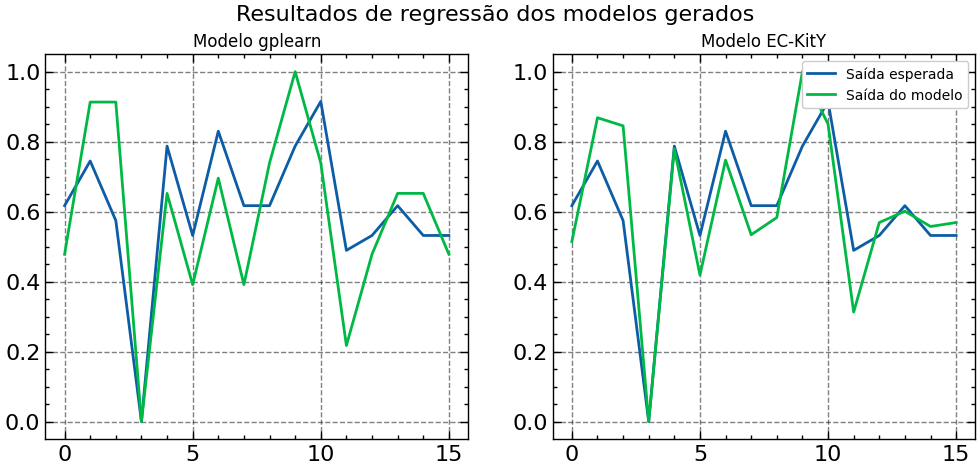

In [231]:
print('''############################################################################################################
#######                                      Pacote gplearn                                          #######
############################################################################################################''')

vineyardPredictGplearnResults = []
vineyardMetricsGplearnResults = []

testSize = 5
for iter in range(testSize):
    
    print('''\n------------------------------------------------------------------------------------\n'''+
    f'''                                Iteração {iter+1} de {testSize}\n'''+
    '''---- ------------------------- ------------------------------------------ ----------''')
    
    # Treina e testa modelo
    beginTime = time.time()
    vineyardPredictGplearn, vineyardMetricsGplearn = trainTestGplearn(xVineyardTrain, yVineyardTrain, 
                                                        xVineyardTest, yVineyardTest, 
                                                        'regression', 
                                                        population_size=300,
                                                        generations=50)
    endTime = time.time()
    timeSpent = endTime - beginTime
    vineyardMetricsGplearn.append(timeSpent)
    
    # Atualiza vetor de resultados
    vineyardPredictGplearnResults.append(vineyardPredictGplearn)
    vineyardMetricsGplearnResults.append(vineyardMetricsGplearn)


print('''\n\n############################################################################################################
#######                                     Pacote EC-KitY                                           #######
############################################################################################################''')

vineyardPredictECKitYResults = []
vineyardMetricsECKitYResults = []

for iter in range(testSize):

    print('''\n------------------------------------------------------------------------------------\n'''+
    f'''                                  Iteração {iter+1} de {testSize}\n'''+
    '''------------------------------------------------------------------------------------\n''')
    
    # Treina e testa modelo
    beginTime = time.time()
    vineyardPredictECKitY, vineyardMetricsECKitY = trainTestECKitY(xVineyardTrain, yVineyardTrain, 
                                                        xVineyardTest, yVineyardTest, 
                                                        'regression', 
                                                        population_size=300,
                                                        generations=50)
    endTime = time.time()
    timeSpent = endTime - beginTime
    vineyardMetricsECKitY.append(timeSpent)
    
    # Atualiza vetor de resultados
    vineyardPredictECKitYResults.append(vineyardPredictECKitY)
    vineyardMetricsECKitYResults.append(vineyardMetricsECKitY)
    
plotRegressions(yVineyardTest, 
                np.mean(vineyardPredictGplearnResults, axis=0), 
                np.mean(vineyardPredictECKitYResults,axis=0))

#### 2. Pollution

############################################################################################################
#######                                      Pacote gplearn                                          #######
############################################################################################################

------------------------------------------------------------------------------------
                                Iteração 1 de 5
---- ------------------------- ------------------------------------------ ----------
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.99         0.533116        3         0.132251         0.224974     12.88s
   1     3.50         0.281395        2         0.133792         0.305921     13.53s
   2     2.13         0.176553        2

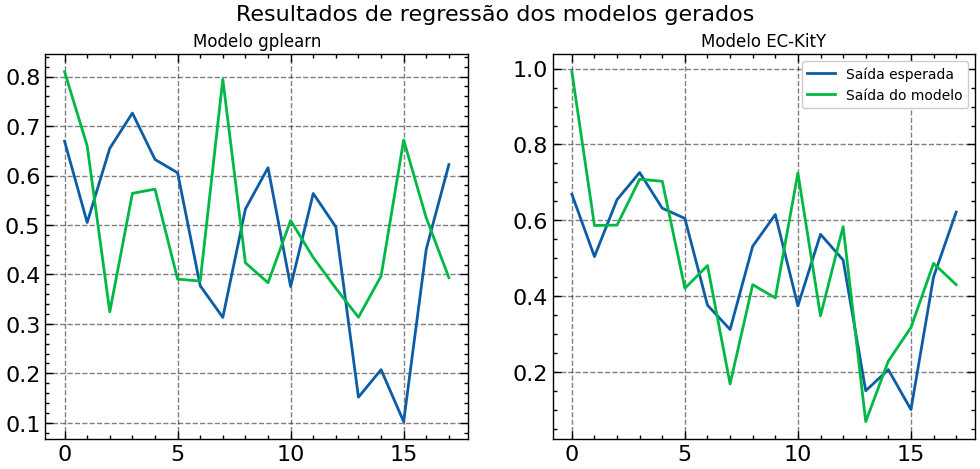

In [232]:
print('''############################################################################################################
#######                                      Pacote gplearn                                          #######
############################################################################################################''')

pollutionPredictGplearnResults = []
pollutionMetricsGplearnResults = []

testSize = 5
for iter in range(testSize):
    
    print('''\n------------------------------------------------------------------------------------\n'''+
    f'''                                Iteração {iter+1} de {testSize}\n'''+
    '''---- ------------------------- ------------------------------------------ ----------''')
    
    # Treina e testa modelo
    beginTime = time.time()
    pollutionPredictGplearn, pollutionMetricsGplearn = trainTestGplearn(xPollutionTrain, yPollutionTrain, 
                                                        xPollutionTest, yPollutionTest, 
                                                        'regression', 
                                                        population_size=300,
                                                        generations=50)
    endTime = time.time()
    timeSpent = endTime - beginTime
    pollutionMetricsGplearn.append(timeSpent)
    
    # Atualiza vetor de resultados
    pollutionPredictGplearnResults.append(pollutionPredictGplearn)
    pollutionMetricsGplearnResults.append(pollutionMetricsGplearn)


print('''\n\n############################################################################################################
#######                                     Pacote EC-KitY                                           #######
############################################################################################################''')

pollutionPredictECKitYResults = []
pollutionMetricsECKitYResults = []

for iter in range(testSize):

    print('''\n------------------------------------------------------------------------------------\n'''+
    f'''                                  Iteração {iter+1} de {testSize}\n'''+
    '''------------------------------------------------------------------------------------\n''')
    
    # Treina e testa modelo
    beginTime = time.time()
    pollutionPredictECKitY, pollutionMetricsECKitY = trainTestECKitY(xPollutionTrain, yPollutionTrain, 
                                                        xPollutionTest, yPollutionTest, 
                                                        'regression', 
                                                        population_size=300,
                                                        generations=50)
    endTime = time.time()
    timeSpent = endTime - beginTime
    pollutionMetricsECKitY.append(timeSpent)
    
    # Atualiza vetor de resultados
    pollutionPredictECKitYResults.append(pollutionPredictECKitY)
    pollutionMetricsECKitYResults.append(pollutionMetricsECKitY)
    
plotRegressions(yPollutionTest, 
                np.mean(pollutionPredictGplearnResults, axis=0), 
                np.mean(pollutionPredictECKitYResults,axis=0))

#### 3. BodyFat

############################################################################################################
#######                                      Pacote gplearn                                          #######
############################################################################################################

------------------------------------------------------------------------------------
                                Iteração 1 de 5
---- ------------------------- ------------------------------------------ ----------
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    12.49         0.497419        4         0.053357        0.0404099     11.49s
   1     2.86          0.19436        4        0.0475427        0.0914464     10.12s
   2     3.49         0.296849        6

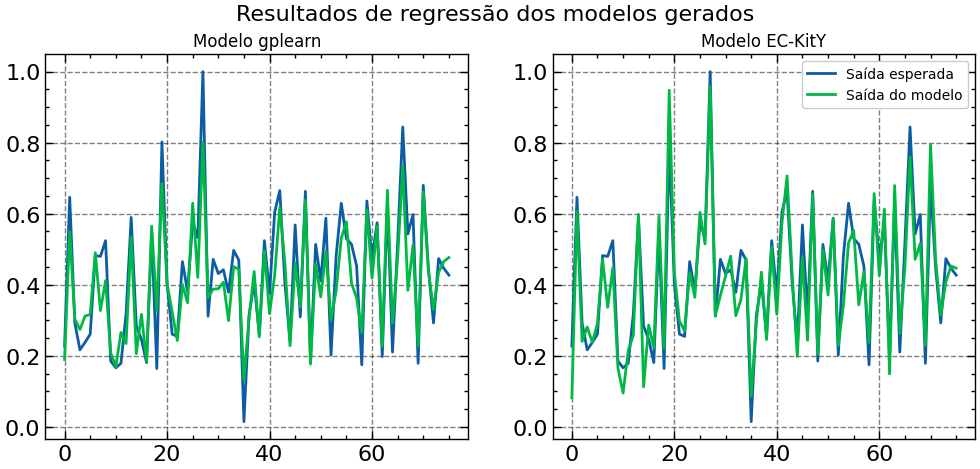

In [233]:
print('''############################################################################################################
#######                                      Pacote gplearn                                          #######
############################################################################################################''')

bodyFatPredictGplearnResults = []
bodyFatMetricsGplearnResults = []

testSize = 5
for iter in range(testSize):
    
    print('''\n------------------------------------------------------------------------------------\n'''+
    f'''                                Iteração {iter+1} de {testSize}\n'''+
    '''---- ------------------------- ------------------------------------------ ----------''')
    
    # Treina e testa modelo
    beginTime = time.time()
    bodyFatPredictGplearn, bodyFatMetricsGplearn = trainTestGplearn(xBodyFatTrain, yBodyFatTrain, 
                                                        xBodyFatTest, yBodyFatTest, 
                                                        'regression', 
                                                        population_size=300,
                                                        generations=50)
    endTime = time.time()
    timeSpent = endTime - beginTime
    bodyFatMetricsGplearn.append(timeSpent)
    
    # Atualiza vetor de resultados
    bodyFatPredictGplearnResults.append(bodyFatPredictGplearn)
    bodyFatMetricsGplearnResults.append(bodyFatMetricsGplearn)


print('''\n\n############################################################################################################
#######                                     Pacote EC-KitY                                           #######
############################################################################################################''')

bodyFatPredictECKitYResults = []
bodyFatMetricsECKitYResults = []

for iter in range(testSize):

    print('''\n------------------------------------------------------------------------------------\n'''+
    f'''                                  Iteração {iter+1} de {testSize}\n'''+
    '''------------------------------------------------------------------------------------\n''')
    
    # Treina e testa modelo
    beginTime = time.time()
    bodyFatPredictECKitY, bodyFatMetricsECKitY = trainTestECKitY(xBodyFatTrain, yBodyFatTrain, 
                                                        xBodyFatTest, yBodyFatTest, 
                                                        'regression', 
                                                        population_size=300,
                                                        generations=50)
    endTime = time.time()
    timeSpent = endTime - beginTime
    bodyFatMetricsECKitY.append(timeSpent)
    
    # Atualiza vetor de resultados
    bodyFatPredictECKitYResults.append(bodyFatPredictECKitY)
    bodyFatMetricsECKitYResults.append(bodyFatMetricsECKitY)
    
plotRegressions(yBodyFatTest, 
                np.mean(bodyFatPredictGplearnResults, axis=0), 
                np.mean(bodyFatPredictECKitYResults,axis=0))

```

### Classificação

#### 1. Iris

############################################################################################################
#######                                      Pacote gplearn                                          #######
############################################################################################################

------------------------------------------------------------------------------------
                                Iteração 1 de 5
---- ------------------------- ------------------------------------------ ----------
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    13.68          2.13905        7      6.52374e-06      5.52954e-06     14.56s

------------------------------------------------------------------------------------
                                Iteraç

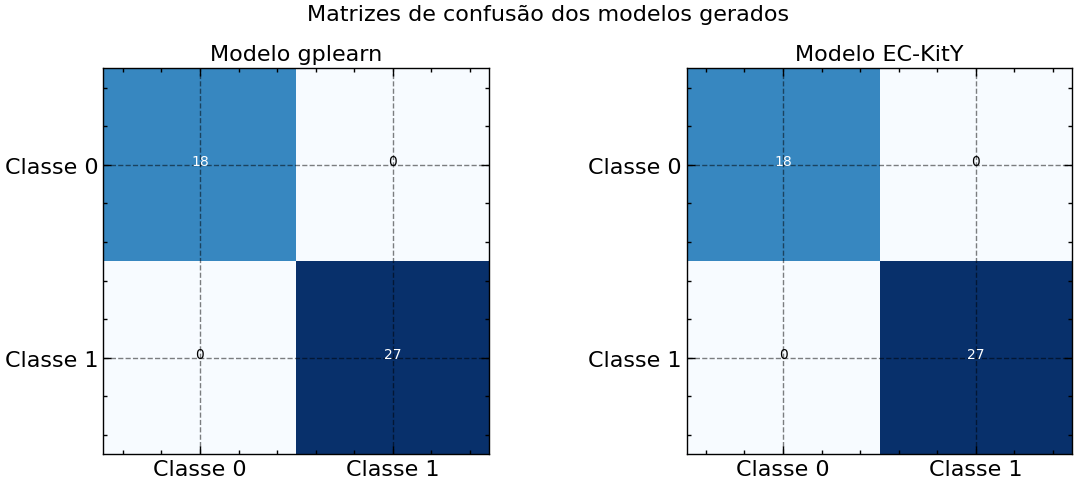

In [235]:
print('''############################################################################################################
#######                                      Pacote gplearn                                          #######
############################################################################################################''')

irisPredictGplearnResults = []
irisMetricsGplearnResults = []

testSize = 5
for iter in range(testSize):
    
    print('''\n------------------------------------------------------------------------------------\n'''+
    f'''                                Iteração {iter+1} de {testSize}\n'''+
    '''---- ------------------------- ------------------------------------------ ----------''')
    
    # Treina e testa modelo
    beginTime = time.time()
    irisPredictGplearn, irisMetricsGplearn = trainTestGplearn(xIrisTrain, yIrisTrain, 
                                                        xIrisTest, yIrisTest, 
                                                        'classification', 
                                                        population_size=300,
                                                        generations=50)
    endTime = time.time()
    timeSpent = endTime - beginTime
    irisMetricsGplearn.append(timeSpent)
    
    # Atualiza vetor de resultados
    irisPredictGplearnResults.append(irisPredictGplearn)
    irisMetricsGplearnResults.append(irisMetricsGplearn)


print('''\n\n############################################################################################################
#######                                     Pacote EC-KitY                                           #######
############################################################################################################''')

irisPredictECKitYResults = []
irisMetricsECKitYResults = []

for iter in range(testSize):

    print('''\n------------------------------------------------------------------------------------\n'''+
    f'''                                  Iteração {iter+1} de {testSize}\n'''+
    '''------------------------------------------------------------------------------------\n''')
    
    # Treina e testa modelo
    beginTime = time.time()
    irisPredictECKitY, irisMetricsECKitY = trainTestECKitY(xIrisTrain, yIrisTrain, 
                                                        xIrisTest, yIrisTest, 
                                                        'classification', 
                                                        population_size=300,
                                                        generations=50)
    endTime = time.time()
    timeSpent = endTime - beginTime
    irisMetricsECKitY.append(timeSpent)
    
    # Atualiza vetor de resultados
    irisPredictECKitYResults.append(irisPredictECKitY)
    irisMetricsECKitYResults.append(irisMetricsECKitY)
    
# Plot dos resultados
plotConfusionMatrixes(yIrisTest, 
                      np.round(np.mean(irisPredictGplearnResults, axis=0)), 
                      np.round(np.mean(irisPredictECKitYResults, axis=0)))

#### 2. BreastCancerWisconsin

############################################################################################################
#######                                      Pacote gplearn                                          #######
############################################################################################################

------------------------------------------------------------------------------------
                                Iteração 1 de 5
---- ------------------------- ------------------------------------------ ----------
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.99          4.86231       51          0.54763         0.484823     13.84s
   1     2.90         0.955504       14         0.602957         0.596355     11.32s
   2     2.89          1.21057        5

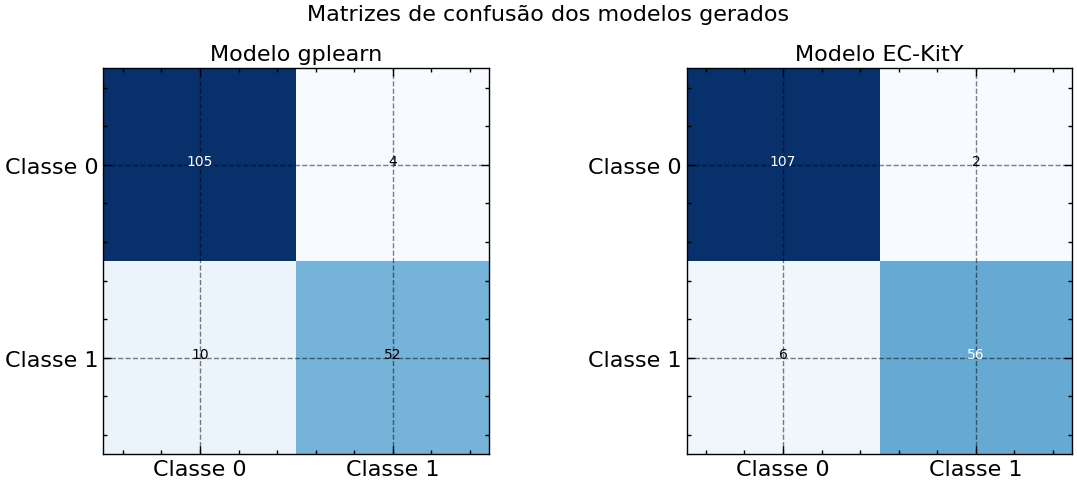

In [236]:
print('''############################################################################################################
#######                                      Pacote gplearn                                          #######
############################################################################################################''')

breastCancerPredictGplearnResults = []
breastCancerMetricsGplearnResults = []

testSize = 5
for iter in range(testSize):
    
    print('''\n------------------------------------------------------------------------------------\n'''+
    f'''                                Iteração {iter+1} de {testSize}\n'''+
    '''---- ------------------------- ------------------------------------------ ----------''')
    
    # Treina e testa modelo
    beginTime = time.time()
    breastCancerPredictGplearn, breastCancerMetricsGplearn = trainTestGplearn(xBreastCancerTrain, yBreastCancerTrain, 
                                                        xBreastCancerTest, yBreastCancerTest, 
                                                        'classification', 
                                                        population_size=300,
                                                        generations=50)
    endTime = time.time()
    timeSpent = endTime - beginTime
    breastCancerMetricsGplearn.append(timeSpent)
    
    # Atualiza vetor de resultados
    breastCancerPredictGplearnResults.append(breastCancerPredictGplearn)
    breastCancerMetricsGplearnResults.append(breastCancerMetricsGplearn)


print('''\n\n############################################################################################################
#######                                     Pacote EC-KitY                                           #######
############################################################################################################''')

breastCancerPredictECKitYResults = []
breastCancerMetricsECKitYResults = []

for iter in range(testSize):

    print('''\n------------------------------------------------------------------------------------\n'''+
    f'''                                  Iteração {iter+1} de {testSize}\n'''+
    '''------------------------------------------------------------------------------------\n''')
    
    # Treina e testa modelo
    beginTime = time.time()
    breastCancerPredictECKitY, breastCancerMetricsECKitY = trainTestECKitY(xBreastCancerTrain, yBreastCancerTrain, 
                                                        xBreastCancerTest, yBreastCancerTest, 
                                                        'classification', 
                                                        population_size=300,
                                                        generations=50)
    endTime = time.time()
    timeSpent = endTime - beginTime
    breastCancerMetricsECKitY.append(timeSpent)
    
    # Atualiza vetor de resultados
    breastCancerPredictECKitYResults.append(breastCancerPredictECKitY)
    breastCancerMetricsECKitYResults.append(breastCancerMetricsECKitY)
    
# Plot dos resultados
plotConfusionMatrixes(yBreastCancerTest, 
                      np.round(np.mean(breastCancerPredictGplearnResults, axis=0)),
                      np.round(np.mean(breastCancerPredictECKitYResults, axis=0)))

#### 3. Statlog (Heart)

############################################################################################################
#######                                      Pacote gplearn                                          #######
############################################################################################################

------------------------------------------------------------------------------------
                                Iteração 1 de 5
---- ------------------------- ------------------------------------------ ----------
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.64          4.58671        2         0.561713          0.64112     14.28s
   1     3.52          1.29358        8         0.543284         0.828327     12.49s
   2     2.53          1.18774        2

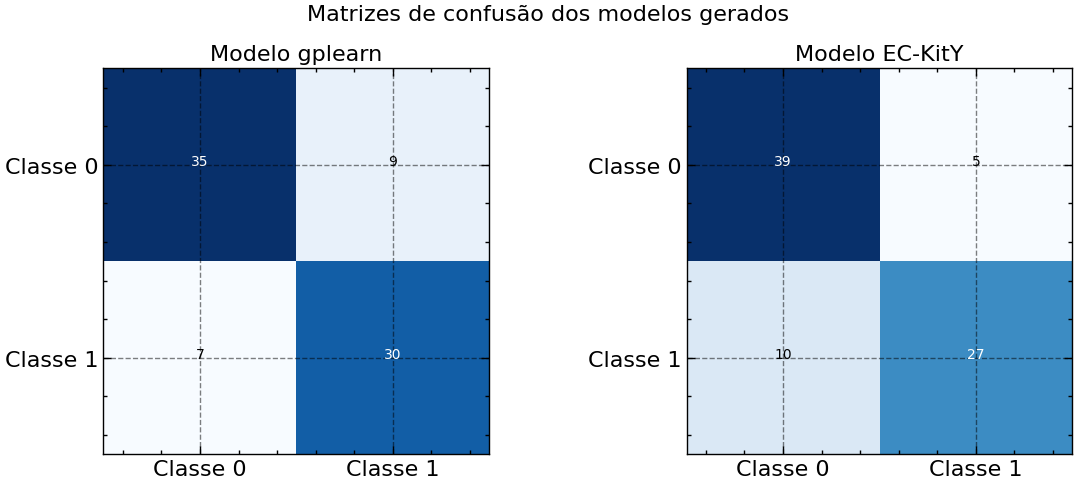

In [237]:
print('''############################################################################################################
#######                                      Pacote gplearn                                          #######
############################################################################################################''')

heartPredictGplearnResults = []
heartMetricsGplearnResults = []

testSize = 5
for iter in range(testSize):
    
    print('''\n------------------------------------------------------------------------------------\n'''+
    f'''                                Iteração {iter+1} de {testSize}\n'''+
    '''---- ------------------------- ------------------------------------------ ----------''')
    
    # Treina e testa modelo
    beginTime = time.time()
    heartPredictGplearn, heartMetricsGplearn = trainTestGplearn(xHeartTrain, yHeartTrain, 
                                                        xHeartTest, yHeartTest, 
                                                        'classification', 
                                                        population_size=300,
                                                        generations=50)
    endTime = time.time()
    timeSpent = endTime - beginTime
    heartMetricsGplearn.append(timeSpent)
    
    # Atualiza vetor de resultados
    heartPredictGplearnResults.append(heartPredictGplearn)
    heartMetricsGplearnResults.append(heartMetricsGplearn)


print('''\n\n############################################################################################################
#######                                     Pacote EC-KitY                                           #######
############################################################################################################''')

heartPredictECKitYResults = []
heartMetricsECKitYResults = []

for iter in range(testSize):

    print('''\n------------------------------------------------------------------------------------\n'''+
    f'''                                  Iteração {iter+1} de {testSize}\n'''+
    '''------------------------------------------------------------------------------------\n''')
    
    # Treina e testa modelo
    beginTime = time.time()
    heartPredictECKitY, heartMetricsECKitY = trainTestECKitY(xHeartTrain, yHeartTrain, 
                                                        xHeartTest, yHeartTest, 
                                                        'classification', 
                                                        population_size=300,
                                                        generations=50)
    endTime = time.time()
    timeSpent = endTime - beginTime
    heartMetricsECKitY.append(timeSpent)
    
    # Atualiza vetor de resultados
    heartPredictECKitYResults.append(heartPredictECKitY)
    heartMetricsECKitYResults.append(heartMetricsECKitY)
    
# Plot dos resultados
plotConfusionMatrixes(yHeartTest, 
                      np.round(np.mean(heartPredictGplearnResults, axis=0)),
                      np.round(np.mean(heartPredictECKitYResults, axis=0)))

### Compilação dos resultados (tabelas)

In [238]:
# Compilando média dos resultados
#
# gplearn
vineyardMetricsGplearnResultsMean = np.mean(np.array(vineyardMetricsGplearnResults), axis=0)
pollutionMetricsGplearnResultsMean = np.mean(np.array(pollutionMetricsGplearnResults), axis=0)
bodyFatMetricsGplearnResultsMean = np.mean(np.array(bodyFatMetricsGplearnResults), axis=0)
irisMetricsGplearnResultsMean = np.mean(np.array(irisMetricsGplearnResults), axis=0)
breastCancerMetricsGplearnResultsMean = np.mean(np.array(breastCancerMetricsGplearnResults), axis=0)
heartMetricsGplearnResultsMean = np.mean(np.array(heartMetricsGplearnResults), axis=0)
#
compiledGplearnResultsRegression = np.vstack([vineyardMetricsGplearnResultsMean,
                                             pollutionMetricsGplearnResultsMean,
                                             bodyFatMetricsGplearnResultsMean])
compiledGplearnResultsClassification = np.vstack([irisMetricsGplearnResultsMean,
                                             breastCancerMetricsGplearnResultsMean,
                                             heartMetricsGplearnResultsMean])
#
#
# EC-KitY
vineyardMetricsECKitYResultsMean = np.mean(np.array(vineyardMetricsECKitYResults), axis=0)
pollutionMetricsECKitYResultsMean = np.mean(np.array(pollutionMetricsECKitYResults), axis=0)
bodyFatMetricsECKitYResultsMean = np.mean(np.array(bodyFatMetricsECKitYResults), axis=0)
irisMetricsECKitYResultsMean = np.mean(np.array(irisMetricsECKitYResults), axis=0)
breastCancerMetricsECKitYResultsMean = np.mean(np.array(breastCancerMetricsECKitYResults), axis=0)
heartMetricsECKitYResultsMean = np.mean(np.array(heartMetricsECKitYResults), axis=0)
#
compiledECKitYResultsRegression = np.vstack([vineyardMetricsECKitYResultsMean,
                                             pollutionMetricsECKitYResultsMean,
                                             bodyFatMetricsECKitYResultsMean])
compiledECKitYResultsClassification = np.vstack([irisMetricsECKitYResultsMean,
                                             breastCancerMetricsECKitYResultsMean,
                                             heartMetricsECKitYResultsMean])

compiledRegressionResultsTable = pd.DataFrame({
    ('','Base de dados'): ['Vineyard', 'Pollution', 'BodyFat'],
    ('gplearn', 'MSE'): np.round(compiledGplearnResultsRegression[:,0],2),
    ('gplearn', 'MAE'): np.round(compiledGplearnResultsRegression[:,1],2),
    ('gplearn', 'R²'): np.round(compiledGplearnResultsRegression[:,2],2),
    ('gplearn', 'Tempo de execução (s)'): np.round(compiledGplearnResultsRegression[:,3],2),
    ('EC-KitY', 'MSE'): np.round(compiledECKitYResultsRegression[:,0],2),
    ('EC-KitY', 'MAE'): np.round(compiledECKitYResultsRegression[:,1],2),
    ('EC-KitY', 'R²'): np.round(compiledECKitYResultsRegression[:,2],2),
    ('EC-KitY', 'Tempo de execução (s)'): np.round(compiledECKitYResultsRegression[:,3],2),
})

compiledClassificationResultsTable = pd.DataFrame({
    ('','Base de dados'): ['Iris', 'BreastCancer', 'Heart'],
    ('gplearn', 'Acurácia'): np.round(compiledGplearnResultsClassification[:,0],2),
    ('gplearn', 'Precisão'): np.round(compiledGplearnResultsClassification[:,1],2),
    ('gplearn', 'Recall'): np.round(compiledGplearnResultsClassification[:,2],2),
    ('gplearn', 'F1'): np.round(compiledGplearnResultsClassification[:,3],2),
    ('gplearn', 'Tempo de execução (s)'): np.round(compiledGplearnResultsClassification[:,4],2),
    ('EC-KitY', 'Acurácia'): np.round(compiledECKitYResultsClassification[:,0],2),
    ('EC-KitY', 'Precisão'): np.round(compiledECKitYResultsClassification[:,1],2),
    ('EC-KitY', 'Recall'): np.round(compiledECKitYResultsClassification[:,2],2),
    ('EC-KitY', 'F1'): np.round(compiledECKitYResultsClassification[:,3],2),
    ('EC-KitY', 'Tempo de execução (s)'): np.round(compiledECKitYResultsClassification[:,4],2),
})

# Aplica o estilo para centralizar os nomes das colunas e os dados
compiledRegressionResultsTable_styled = compiledRegressionResultsTable.style.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])
compiledClassificationResultsTable_styled = compiledClassificationResultsTable.style.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])


#### 1. Problemas de Regressão

In [239]:
display(compiledRegressionResultsTable_styled)

#### 2. Problemas de Classificação

In [240]:
display(compiledClassificationResultsTable_styled)

---

## Discussão

Em geral, a biblioteca _EC-KitY_ apresentou resultados visual e quantitativamente melhores que a _gplearn_, sendo capaz de aproximar satisfatoriamente os valores pontuais da saída nos problemas de regressão e classificar corretamente a maior parte das amostras de teste. Apesar dos modelos da _gplearn_ também terem resultado em boas métricas, o seu desempenho foi menos satisfatório para os problemas de regressão, uma vez que, para obter um MSE baixo, alguns modelos tenderam à média dos dados de teste, comportamento pouco desejável para o trabalho com séries temporais, por exemplo. 

Para os _datasets_ de regressão, o pacote _gplearn_ superou o desempenho do _EC-KitY_ apenas no conjunto de dados BodyFat, com os modelos da primeira apresentando um menor MSE e um maior coeficiente R² se comparados ao da última, ainda que com um tempo de execução ligeiramente maior. Já para os _datasets_ de classificação, os modelos da _gplearn_ apresentaram, de modo geral, desempenho inferior aos da _EC-KitY_, superando a última em apenas uma das métricas avaliadas nos datasets BreastCancer e Heart. No dataset Iris, ambos os modelos foram capazes de classificar corretamente todas as amostras, não havendo informações suficientes para comparar o desempenho das duas bibliotecas nesse caso.

Por outro lado, a adaptação ao uso do _EC-KitY_ foi mais lenta do que ao uso da _gplearn_ devido à estrutura menos intuitiva das suas funções e classes, bem como à documentação relativamente escassa da biblioteca.

No geral, os modelos obtiveram melhores resultados para probabilidades altas de recombinação (> 0.7) e probabilidades baixas (mas não nulas) de mutação. Isso pode ser explicado pelo fato da mutação causar mudanças muito significativas no comportamento dos modelos, dado que cada indivíduo é uma expressão simbólica, sendo mais importante recombinar frequentemente os bons indivíduos de forma que o mínimo (ou o máximo) da função de custo seja alcançado mais rapidamente. Ainda assim, é fundamental que as probabilidades de mutação não fiquem excessivamente próximas de zero, uma vez que isso pode acarretar em uma convergência mais lenta dos métodos e na necessidade de aumentar o tamanho da população ou o número máximo de iterações.